In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.datasets import CachedDatasets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import seaborn as sbn

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import os

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

#from kneed import KneeLocator

#from tslearn.preprocessing import TimeSeriesScalerMinMax
#from tslearn.shapelets import LearningShapelets
#from tensorflow.keras.optimizers import Adam

In [11]:
os.listdir('../data/HER2/')

['H210122_SKBR3',
 'H210205_Set1',
 'H210205_Set2',
 'H210212_Set1',
 'H210212_Set2',
 'H210219_Set1',
 'H210219_Set2']

In [12]:
load = 'normalized' # or 'raw'

series_sel = pd.read_csv('../data/HER2/H210122_SKBR3/normalized/clover_all_cell.csv').columns[1:-3]

_datas = []
for dataset in os.listdir('../data/HER2'): 
    cl_path = '../data/HER2/' + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = '../data/HER2/' + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)
    
data = pd.concat(_datas, axis=0)

clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()

,track_index,0.0_x,0.2_x,0.5_x,0.8_x,1.0_x,1.2_x,1.5_x,1.8_x,2.0_x,...,57.5_y,57.8_y,58.0_y,58.2_y,site_y,median_y,dataset,drug,cell_line,mutant
0,69_1000049620_skbr3_erk_akt__WT_untreated,0.784316,0.786841,0.603200,0.541081,0.458533,0.431992,0.712106,0.699950,0.730170,...,0.242807,0.127572,0.132009,0.047259,69,0.299107,H210122_SKBR3,untreated,skbr3,WT
1,2_1000028311_skbr3_erk_akt__WT_untreated,0.602541,0.605066,0.421425,0.605618,0.691947,0.672889,0.614016,0.661317,0.682537,...,0.557662,0.562536,0.564215,0.564624,2,0.693558,H210122_SKBR3,untreated,skbr3,WT
2,69_1000046124_skbr3_erk_akt__WT_untreated,0.777447,0.753066,0.476562,0.595350,0.605771,0.767272,0.737938,0.733756,0.776656,...,0.522485,0.451602,0.484998,0.550944,69,0.509604,H210122_SKBR3,untreated,skbr3,WT
3,0_1000000658_skbr3_erk_akt__WT_untreated,0.831403,0.652266,0.454141,0.696562,0.757371,0.882979,0.805273,0.936487,0.915338,...,0.779451,0.878771,0.866162,0.826636,0,0.607951,H210122_SKBR3,untreated,skbr3,WT
4,75_1000100136_skbr3_erk_akt__WT_untreated,0.165367,0.141473,0.447377,0.482309,0.478944,0.658566,0.682605,0.727898,0.744381,...,0.562468,0.551105,0.634450,0.626864,75,0.668938,H210122_SKBR3,untreated,skbr3,WT


In [16]:
type(clover_sel)

list

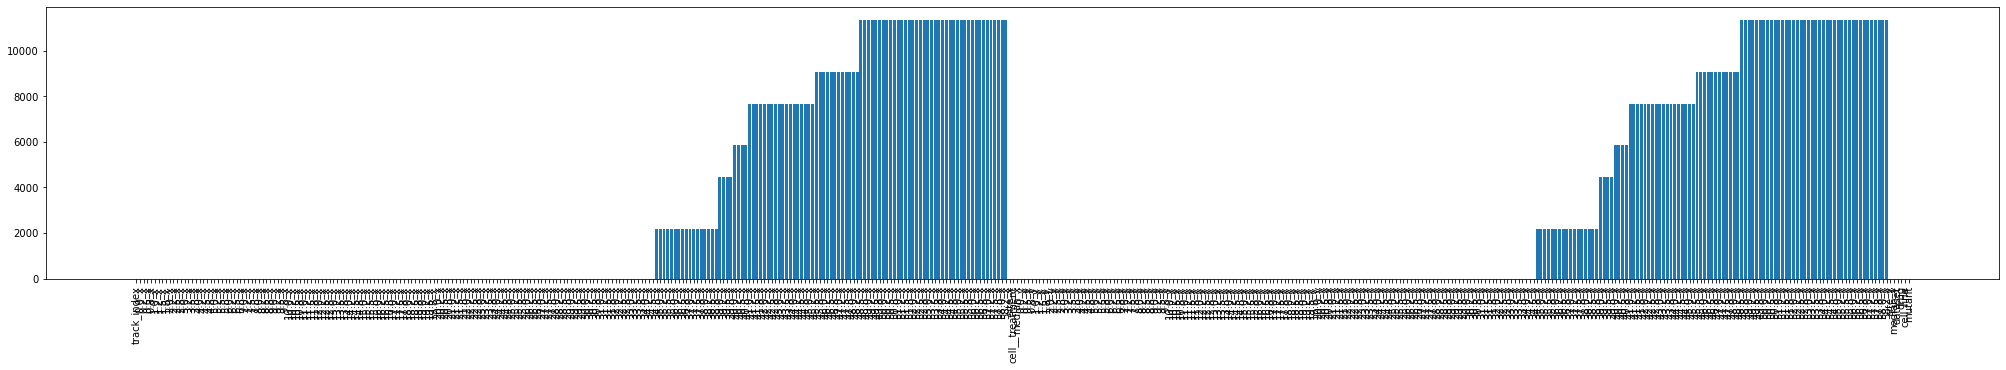

In [19]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

In [20]:
data = data[lambda x: x.drug.isin(['untreated', '10nm_neratinib'])]
data.shape

(9522, 478)

In [21]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

KeyboardInterrupt: 

In [22]:
# remove na
clover_sel = np.array(clover_sel)[~data[clover_sel].isna().any()]
mscarl_sel = np.array(mscarl_sel)[~data[mscarl_sel].isna().any()]

In [23]:
#X_train = data[clover_sel]
X_train = np.stack([data[clover_sel], data[mscarl_sel]], axis=2)
print(X_train.shape)

sz = 125
# Make time series shorter
X_train2 = TimeSeriesResampler(sz=sz).fit_transform(X_train)
#sz = X_train2.shape[1]
print(X_train2.shape)

(9522, 139, 2)
(9522, 125, 2)


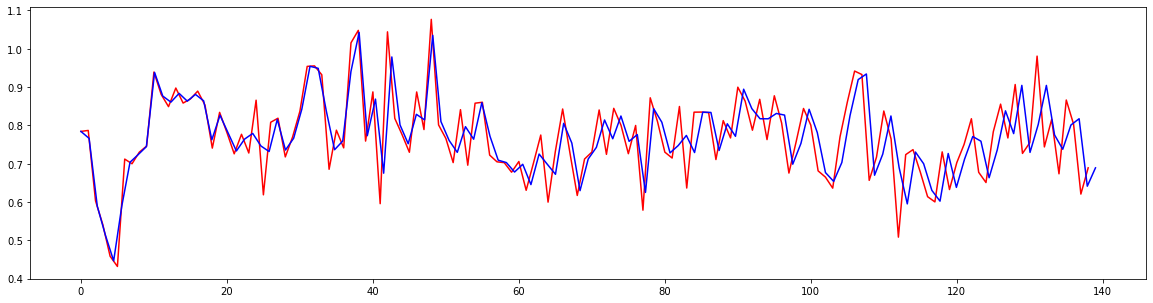

In [24]:
plt.figure(figsize=(20,5))
plt.plot(X_train[0, :, 0], 'r-')
xx = np.linspace(0, X_train.shape[1], sz)
yy = X_train2[0, :, 0]
plt.plot(xx, yy, 'b-')
plt.show()

In [25]:
X_train = X_train2

# Choose # of Clusters

In [26]:
if False: 
    clus_res = {'n':[] , 'inertia':[]}
    for n in np.arange(2,35,3):
        print(f'Training kmeans with {n} clusters', end='\r')
        model = TimeSeriesKMeans(n_clusters=n, verbose=False, random_state=0, metric='euclidean', n_jobs=8)
        model.fit(X_train)
        clus_res['n'].append(n)
        clus_res['inertia'].append(model.inertia_)
    clus_res = pd.DataFrame(clus_res)
    
    kneedle = KneeLocator(clus_res.n, clus_res.inertia, S=1.0, curve="convex", direction="decreasing")
    kneedle.plot_knee_normalized()
    print('elbow point:', kneedle.knee_y)

# Cluster

In [43]:
nclus = 25

In [44]:
km = TimeSeriesKMeans(n_clusters=nclus, verbose=True, random_state=0, metric='euclidean', n_jobs=8)
y_pred = km.fit_predict(X_train)

5.652 --> 4.401 --> 4.300 --> 4.257 --> 4.231 --> 4.211 --> 4.196 --> 4.184 --> 4.176 --> 4.171 --> 4.168 --> 4.165 --> 4.163 --> 4.161 --> 4.160 --> 4.159 --> 4.158 --> 4.158 --> 4.157 --> 4.157 --> 4.157 --> 4.156 --> 4.156 --> 4.155 --> 4.155 --> 4.155 --> 4.154 --> 4.154 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.153 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.152 --> 4.151 --> 4.151 --> 4.151 --> 


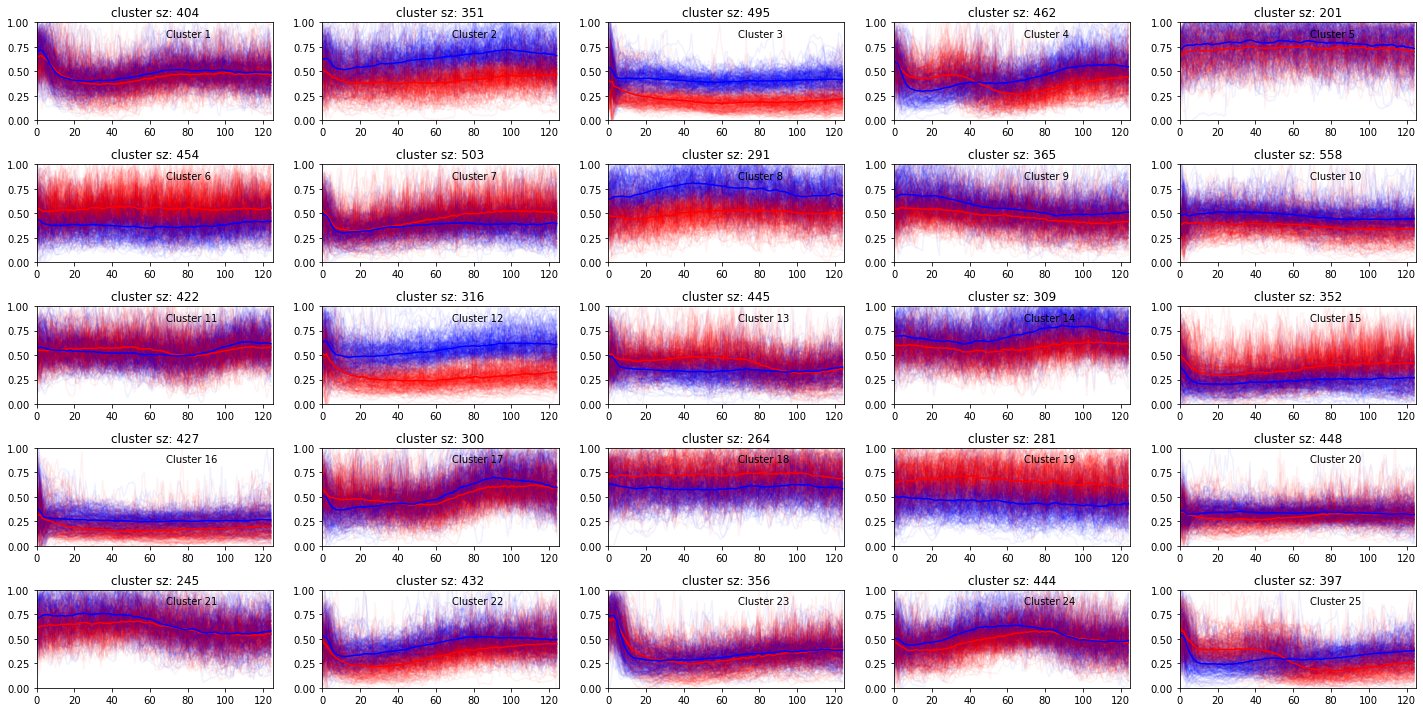

In [45]:
plt.figure(figsize=(20,10))
for yi in range(nclus):
    plt.subplot(5, 5, yi + 1)
    for xx in X_train[y_pred == yi][0:250]:
        plt.plot(xx[:,0], "r-", alpha=.05)
        plt.plot(xx[:,1], "b-", alpha=.05)
        
    plt.title(f'cluster sz: {len(X_train[y_pred == yi])}')
    plt.plot(km.cluster_centers_[yi][:,0], "r-", label='clover')
    plt.plot(km.cluster_centers_[yi][:,1], "b-", label='mscarlet')
    
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [46]:
lb = LabelEncoder()
y_trt = lb.fit_transform([f'{x}--{y}' for x,y in zip(data.cell__treatment.values, data.dataset.values)])

In [47]:
cm_cnts = {c:np.zeros(nclus) for c in lb.classes_} 

In [48]:
for i, clus, grp in zip(range(len(y_pred)), y_pred, y_trt) :
    cm_cnts[lb.classes_[grp]][clus] += 1
    
cm_prob = {k:v/np.sum(v) for k,v in cm_cnts.items()}

In [49]:
labels = [k for k,v in cm_prob.items()]
cm = np.stack([v for k,v in cm_prob.items()], axis=0)

In [50]:
cm.shape

(124, 25)

# Endogenous clusters

Are there any clusters that ALL cells have small proportions of? 

# Cluster co-occurence

/home/teddy/miniconda3/envs/lc_reporter/lib/python3.8/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 504x504 with 0 Axes>

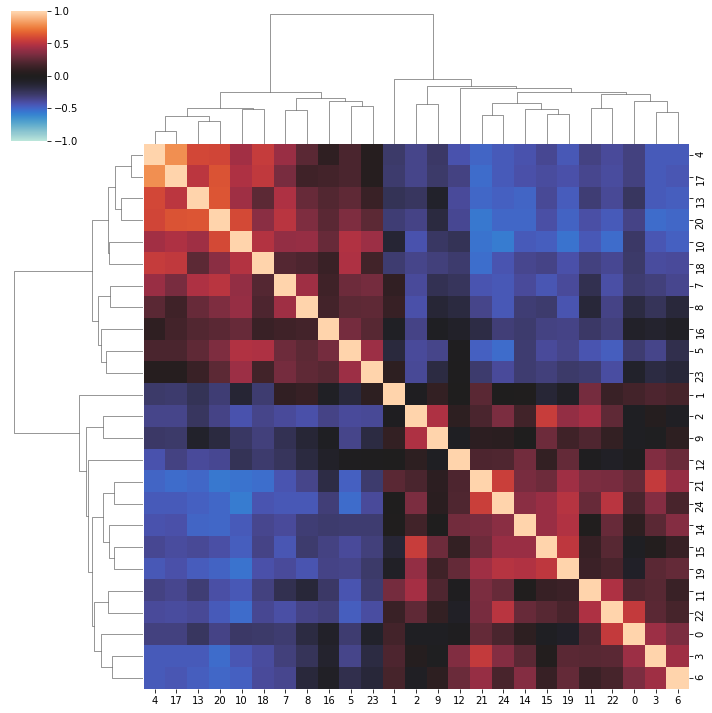

In [51]:
corr = np.corrcoef(cm, rowvar=False)

plt.figure(figsize=(7,7))
ax = sbn.clustermap(
    corr, 
    vmin=-1, vmax=1, center=0,
    square=True
)
plt.show()

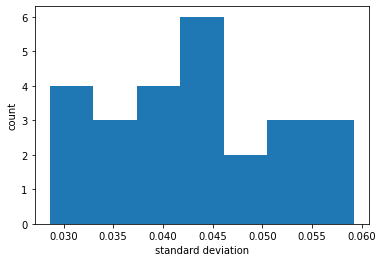

In [52]:
cm_stds = cm.std(axis=0)

plt.figure()
plt.hist(cm_stds, bins=7)
plt.ylabel('count')
plt.xlabel('standard deviation')
plt.show()

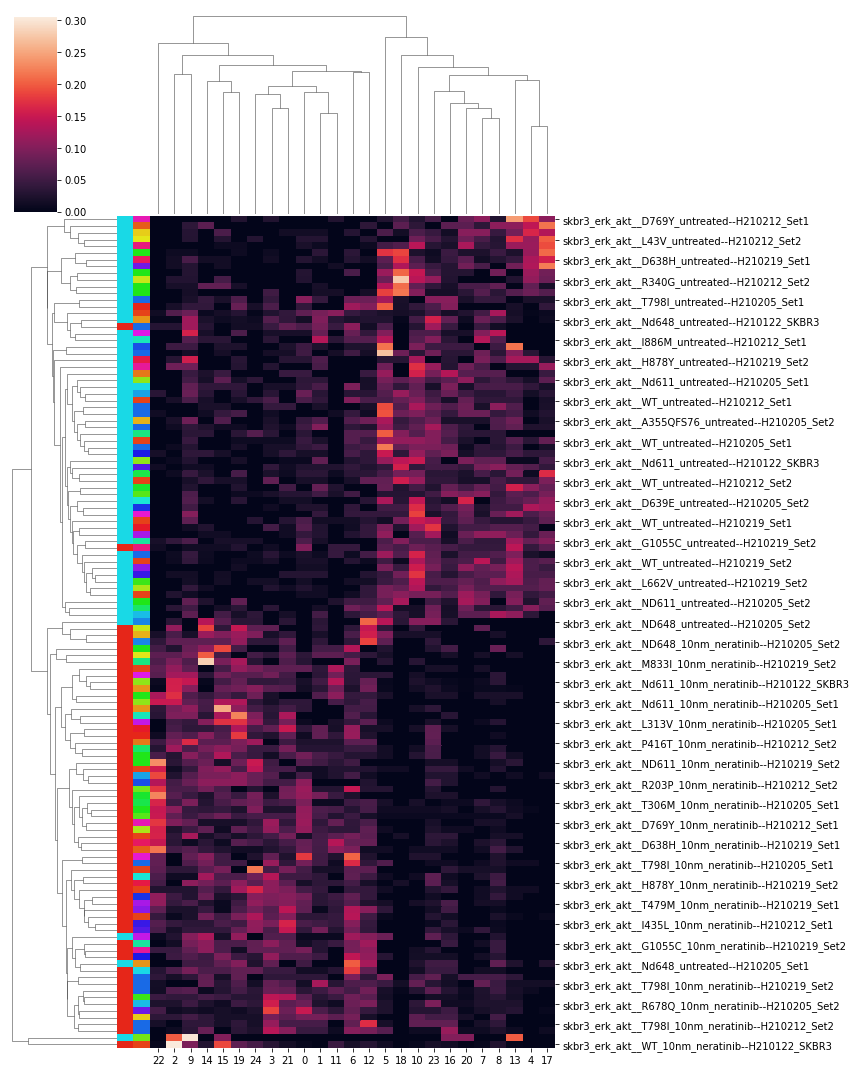

In [53]:
#drug = dict(zip(data.drug.unique(), "rbg"))
#row_colors = data.drug.map(drug)
#g = sbn.clustermap(cm, row_colors=row_colors)
# [x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]

drug = [x.split('--')[0].split('_')[-1] for x in labels]
lut = dict(zip(set(drug), sbn.hls_palette(len(set(drug)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(drug)[0].map(lut)

#Create additional row_colors here
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels, data=cm)
sbn.clustermap(df, figsize=(12,15), row_colors=[row_colors, row_colors2]) 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Clustermap within JUST neratinib

In [54]:
labels2_sel = ['neratinib' in x for x in labels]
labels2 = np.array(labels)[labels2_sel]
cm2 = cm[labels2_sel, :]

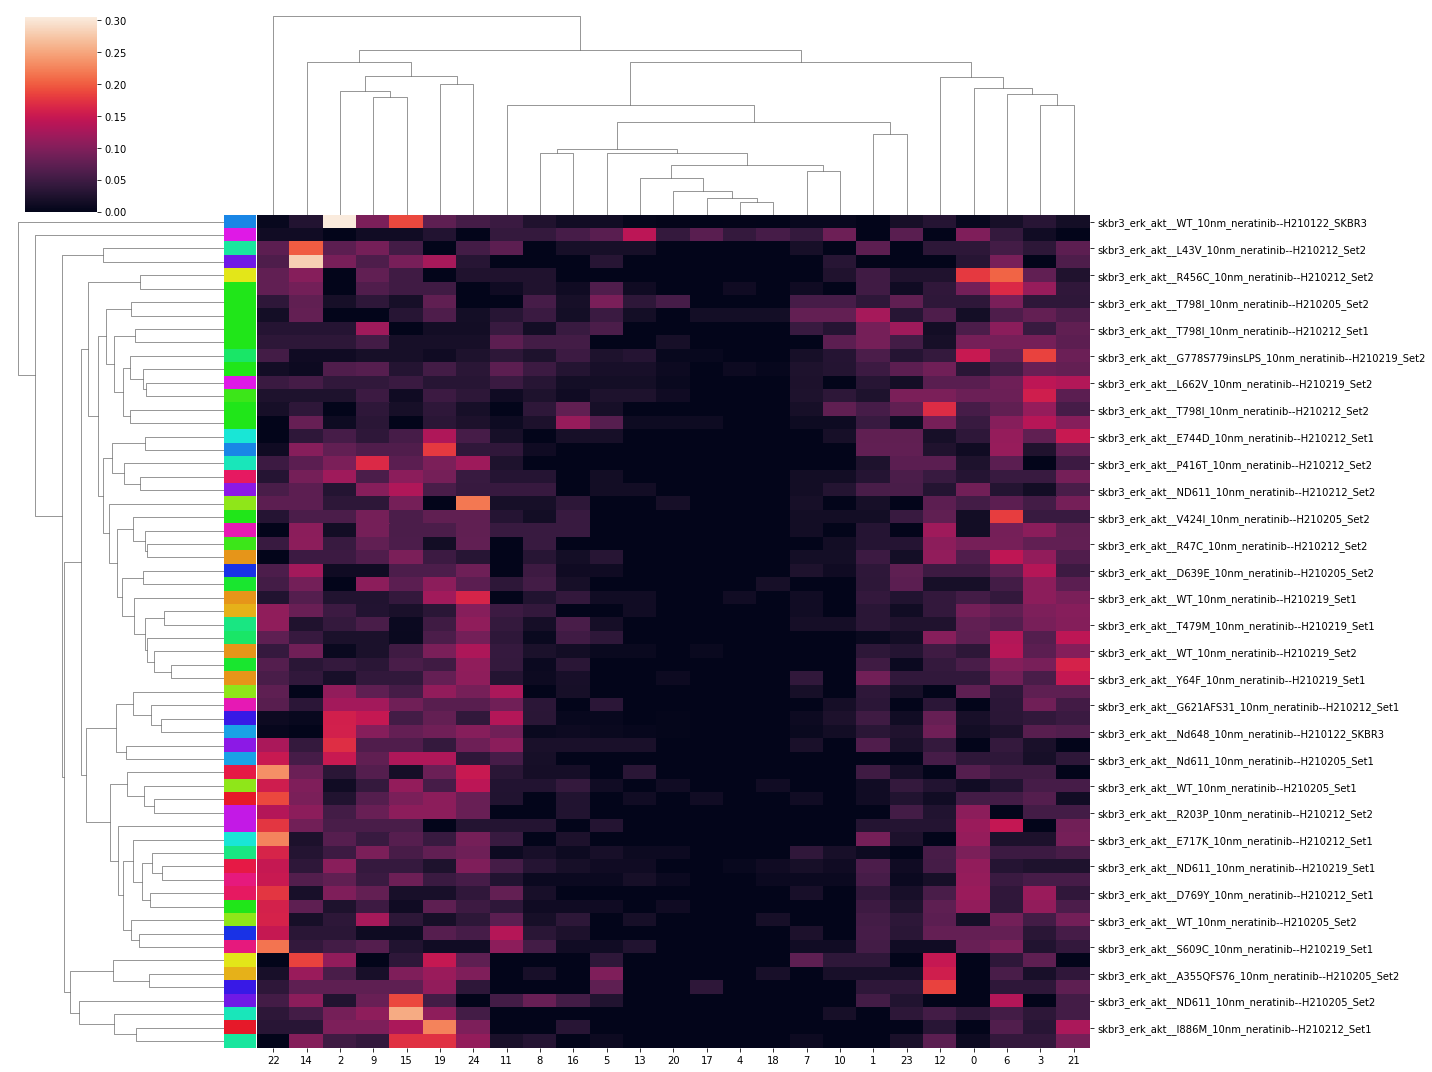

In [55]:
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels2, data=cm2)
sbn.clustermap(df, figsize=(20,15), row_colors=[row_colors2], metric='euclidean') 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Dimensionality Reduction

In [56]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(cm)

print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})
res.head()

explained variance ratio: [0.38062733 0.09634259]
PC shape: (124, 2)


,pc1,pc2,treatment,cell_line
0,-0.102067,-0.062371,neratinib,A355QFS76
1,0.069096,-0.053441,untreated,A355QFS76
2,-0.150977,0.003095,neratinib,D277H
3,0.182980,0.050162,untreated,D277H
4,-0.135082,0.006624,neratinib,D638H


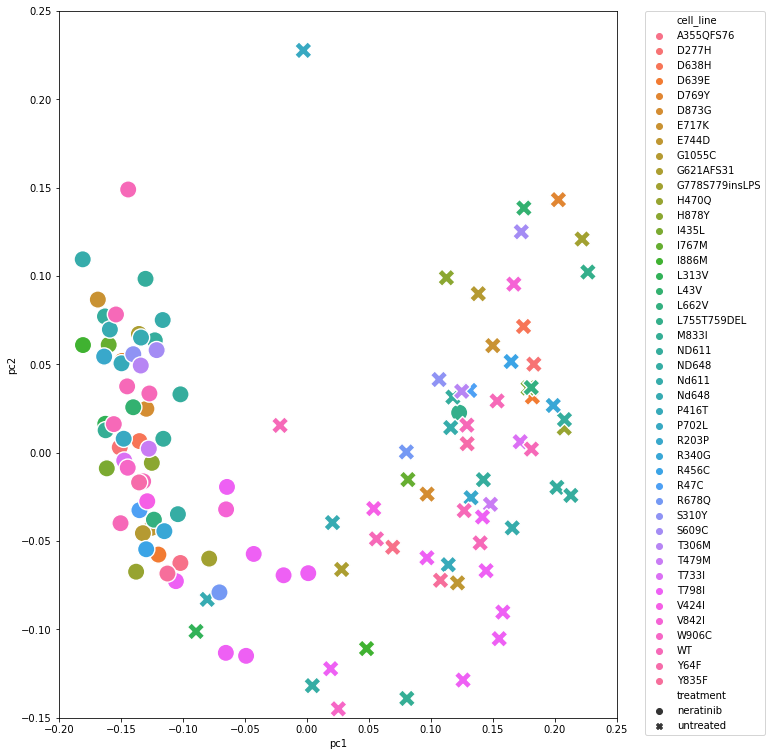

In [64]:
plt.figure(figsize=(10,13))
sbn.scatterplot(x='pc1', y='pc2', data=res, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim((-0.2, 0.25))
plt.ylim((-0.15, 0.25))
plt.show()

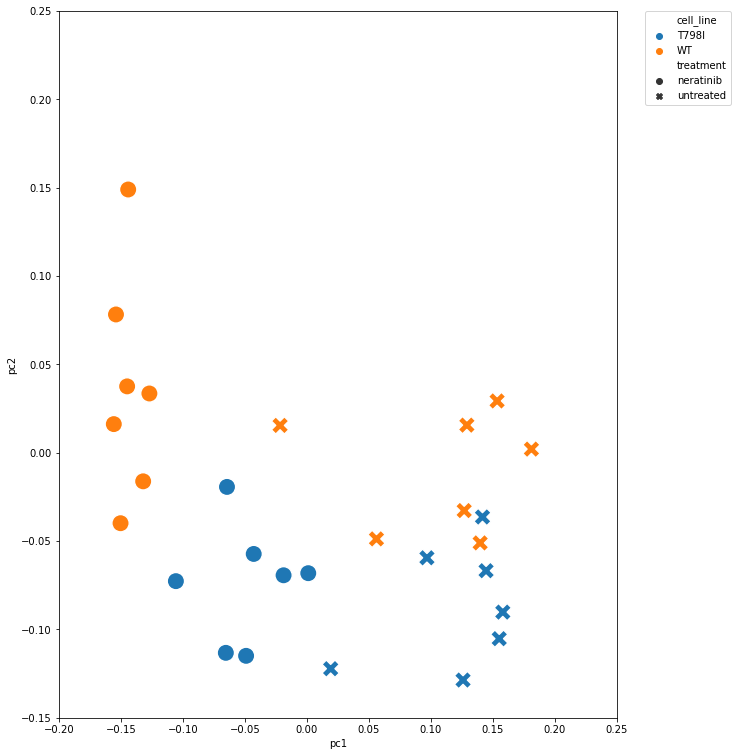

In [65]:
plt.figure(figsize=(10,13))
sbn.scatterplot(x='pc1', y='pc2', data=res[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim((-0.2, 0.25))
plt.ylim((-0.15, 0.25))
plt.show()

In [67]:
res.head()

,pc1,pc2,treatment,cell_line
0,-0.102067,-0.062371,neratinib,A355QFS76
1,0.069096,-0.053441,untreated,A355QFS76
2,-0.150977,0.003095,neratinib,D277H
3,0.182980,0.050162,untreated,D277H
4,-0.135082,0.006624,neratinib,D638H


In [68]:
res_ner = res[lambda x: (x.cell_line.isin(['WT', 'T798I'])) & (x.treatment == 'neratinib')]

In [69]:
X = 5* res_ner[['pc1', 'pc2']].values
y = 1.*((res_ner.cell_line == 'WT') & (res_ner.treatment == 'neratinib')).values #+  2.* (res_ner.treatment == 'untreated').values

In [70]:
np.unique(y)

array([0., 1.])

In [71]:
X.shape

(14, 2)

Accuracy (train) for L1 logistic: 100.0% 
Accuracy (train) for L2 logistic (Multinomial): 100.0% 
Accuracy (train) for L2 logistic (OvR): 100.0% 
Accuracy (train) for Linear SVC: 100.0% 
Accuracy (train) for GPC: 100.0% 


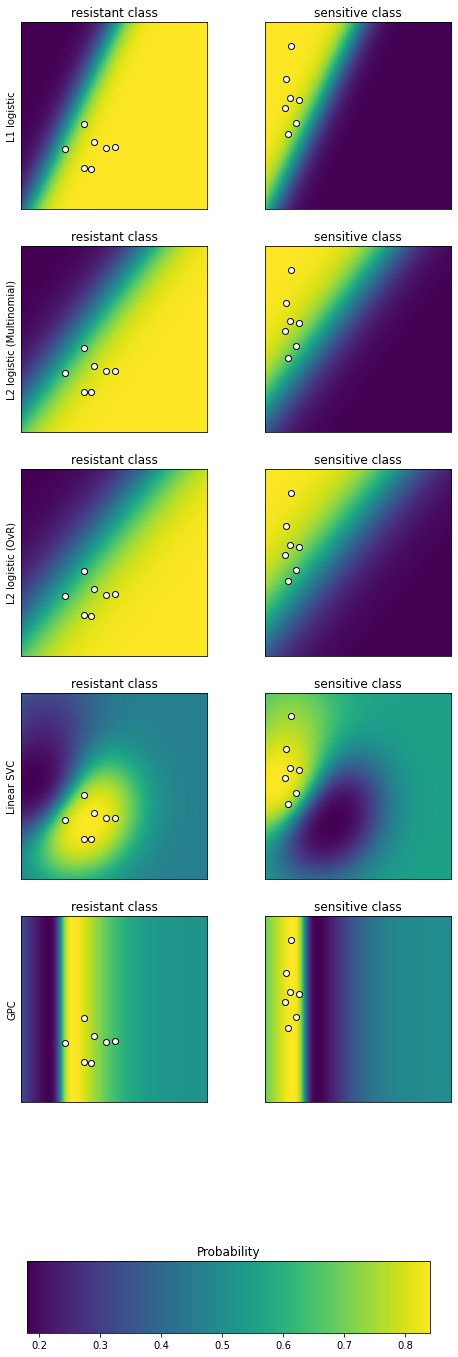

In [80]:
n_features = X.shape[1]

C = 10
kernel = 1. * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='rbf', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel)
}

n_classifiers = len(classifiers)

plt.figure(figsize=(4 * 2, n_classifiers * 4))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

class_names = ['resistant', 'sensitive', 'untreated']
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("%s class" % class_names[k])
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(-1, 1, -1, 1), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [34]:
ner_other = res[lambda x: ~(x.cell_line.isin(['WT', 'T798I'])) & (x.treatment == 'neratinib')].reset_index(drop=True)
ner_other.shape

(48, 4)

In [35]:
X_all = 5*ner_other[['pc1', 'pc2']].values
X_all.shape

(48, 2)

In [36]:
y_hat = classifiers['Linear SVC'].predict_proba(X_all)
y_hat.shape

(48, 2)

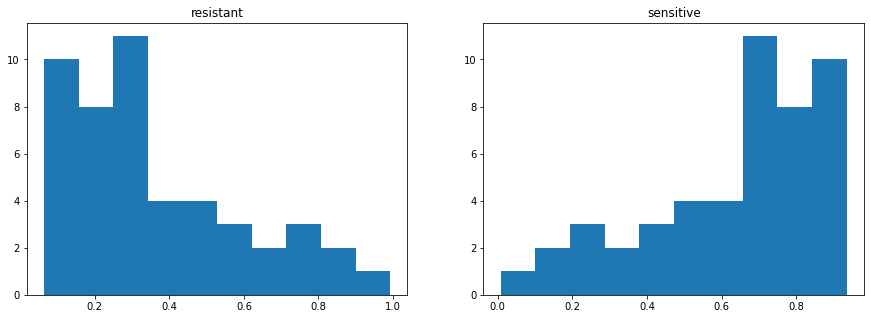

In [37]:
f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(y_hat[:,0])
ax[0].set_title('resistant')
ax[1].hist(y_hat[:,1])
ax[1].set_title('sensitive')
#ax[2].hist(y_hat[:,2])
#ax[2].set_title('untreated')
plt.show()

In [38]:
#del pres
pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1]})#, 'prob_untreat':y_hat[:,2]})
res2 = pd.concat([ner_other, pres], axis=1) # ,'untreat'
res2 = res2.assign(call=[['res','sens'][np.argmax([x,y])] for x,y in zip(res2.prob_res, res2.prob_sens)])#, res2.prob_untreat)])
res2.head()

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
0,-0.177870,-0.134597,neratinib,A355QFS76,0.765428,0.234572,res
1,-0.206830,0.000448,neratinib,D277H,0.325586,0.674414,sens
2,-0.212894,0.022764,neratinib,D638H,0.256769,0.743231,sens
3,-0.208941,-0.045675,neratinib,D639E,0.437139,0.562861,sens
4,-0.241249,0.038032,neratinib,D769Y,0.161281,0.838719,sens


In [39]:
res2.groupby(['call', 'treatment'])[['cell_line']].count()

,,cell_line
call,treatment,
res,neratinib,11
sens,neratinib,37


In [40]:
# 'G778S779insLPS', 'L755T759DEL', 'R456C', 'R678Q', 'T798I', 'V842I', 'Y835F'
res2[lambda x: x.call == 'res'].sort_values('prob_res', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
19,0.192402,0.028282,neratinib,L755T759DEL,0.992113,0.007887,res
47,-0.132126,-0.104849,neratinib,Y835F,0.821855,0.178145,res
10,-0.097308,-0.050594,neratinib,G778S779insLPS,0.809228,0.190772,res
37,-0.108749,-0.060189,neratinib,R678Q,0.799327,0.200673,res
35,-0.146444,-0.096237,neratinib,R456C,0.772686,0.227314,res
0,-0.177870,-0.134597,neratinib,A355QFS76,0.765428,0.234572,res
44,-0.104982,-0.009760,neratinib,V842I,0.707474,0.292526,res
43,-0.120236,-0.023194,neratinib,V424I,0.691320,0.308680,res
25,-0.206359,-0.108004,neratinib,ND611,0.614643,0.385357,res
11,-0.217978,-0.111577,neratinib,H470Q,0.583697,0.416303,res


In [41]:
res2.sort_values('prob_sens', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,call
30,-0.266139,0.098223,neratinib,Nd648,0.064305,0.935695,sens
28,-0.269931,0.092022,neratinib,Nd611,0.065052,0.934948,sens
31,-0.269303,0.071607,neratinib,P416T,0.080778,0.919222,sens
9,-0.214861,0.135484,neratinib,G621AFS31,0.088448,0.911552,sens
16,-0.272127,0.056974,neratinib,L313V,0.090089,0.909911,sens
6,-0.238151,0.099081,neratinib,E717K,0.093187,0.906813,sens
29,-0.190557,0.146990,neratinib,Nd648,0.108966,0.891034,sens
22,-0.213434,0.109273,neratinib,ND611,0.116776,0.883224,sens
13,-0.263422,0.035375,neratinib,I435L,0.124928,0.875072,sens
33,-0.260335,0.020109,neratinib,R203P,0.150227,0.849773,sens


# Shapelets 

In [42]:
data2 = data[lambda x: x.drug.isin(['10nm_neratinib']) & (x.mutant.isin(['WT', 'T798I']))].reset_index(drop=True)

#X_train = data[clover_sel]
X_train = np.stack([data2[clover_sel], data2[mscarl_sel]], axis=2)
print(X_train.shape)

y_train = 1*np.array([x == 'WT' for x in data2.mutant.values])
np.unique(y_train)

(1484, 139, 2)


array([0, 1])

In [43]:
# Author: Gilles Vandewiele
# License: BSD 3 clause

# Set a seed to ensure determinism
np.random.seed(42)

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 2}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(lr=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)

shp_clf.fit(X_train, y_train)

# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
fig_ax3c = fig.add_subplot(gs[2, :2])
fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(numpy.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * numpy.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = numpy.min(distances[:, 0]) - 0.1
xmax = numpy.max(distances[:, 0]) + 0.1
ymin = numpy.min(distances[:, 1]) - 0.1
ymax = numpy.max(distances[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

NameError: name 'TimeSeriesScalerMinMax' is not defined